# torch.distributionsのバッチの処理について

torch.distributionは誤差逆伝播可能なサンプリングを行うことができる．`sample`が通常のサンプリングで，`rsample`が誤差逆伝播可能なサンプリングを行うメソッドである．

torch.distributionsはサンプル時にサイズを指定するので，入力のバッチサイズと出力のバッチサイズが見かけ上異なってしまう．そこで，整理しておく

In [1]:
import torch

In [31]:
import matplotlib.pyplot as plt

以下の例では，平均・分散ともにバッチサイズは3であり，各確率変数の次元は2である．VAEでは，平均と分散をバッチサイズごとに用意し，サンプリングそれぞれひとつづつ行い，結果として全体のサンプリング数がバッチサイズと等しくなる．

In [52]:
one_mean1 = torch.tensor([1,1]).float()
one_mean2 = torch.tensor([2,2]).float()
one_mean3 = torch.tensor([3,3]).float()

mean = torch.stack([one_mean1, one_mean2, one_mean3], dim=0)
print("maen:",mean)

one_var1 = torch.tensor([0.1, 0.1]).float()
one_var2 = torch.tensor([0.1, 0.1]).float()
one_var3 = torch.tensor([0.1, 0.1]).float()

var = torch.stack([one_var1, one_var2, one_var3], dim=0)  # 対角成分のみ
print("var:", var)

var_matrix = var[:,:,None] * torch.eye(var.size(1))[None,:,:]
print("var_matrix:", var_matrix)

maen: tensor([[1., 1.],
        [2., 2.],
        [3., 3.]])
var: tensor([[0.1000, 0.1000],
        [0.1000, 0.1000],
        [0.1000, 0.1000]])
var_matrix: tensor([[[0.1000, 0.0000],
         [0.0000, 0.1000]],

        [[0.1000, 0.0000],
         [0.0000, 0.1000]],

        [[0.1000, 0.0000],
         [0.0000, 0.1000]]])


torch.distributionsのクラスはバッチを考慮してパラメータの指定ができる．

In [53]:
multi_normal = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=var_matrix)

バッチサイズについては`batch_size`でアクセスできる．

In [54]:
multi_normal.batch_shape

torch.Size([3])

一方確率変数の次元については`event_shape`からアクセスできる．

In [55]:
multi_normal.event_shape

torch.Size([2])

`Distribution`クラスの`sample`メソッドはバッチを考慮してサンプリングできるので，バッチサイズ=すべてのサンプリングサイズとなるVAEでは，サンプルサイズを指定しない．

In [56]:
samples = multi_normal.sample()
samples.shape

torch.Size([3, 2])

一つの平均・分散ごとに複数のサンプルを指定するときにサンプルサイズを指定する．以下の例では二つのバッチそれぞれで100個のサンプルをサンプリングしている．

In [57]:
samples = multi_normal.sample(torch.Size([100]))
samples.shape

torch.Size([100, 3, 2])

以下のように，二つ目がバッチ次元になっていることが分かる．

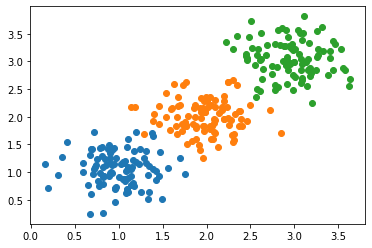

In [58]:
fig, ax = plt.subplots()
for i in range(samples.size(1)):  # バッチ次元
    each_samples = samples[:,i,:]
    each_samples_array = each_samples.numpy()
    ax.scatter(each_samples_array[:,0], each_samples_array[:,1])

以上の例では，わざわざ単位行列を利用して分散を行列にする必要がある．しかし一般にVAEでは分散行列は対角行列であるので，各確率変数の次元は独立である．このように独立性がある場合，`Independent`を利用すれば，一次元の変数の確率分布を用いて多次元の変数を表すことができる

In [68]:
one_mean1 = torch.tensor([1,1]).float()
one_mean2 = torch.tensor([2,2]).float()
one_mean3 = torch.tensor([3,3]).float()

mean = torch.stack([one_mean1, one_mean2, one_mean3], dim=0)
print("maen:",mean)

one_sigma1 = torch.sqrt(torch.tensor([0.1, 0.1]))
one_sigma2 = torch.sqrt(torch.tensor([0.1, 0.1]))
one_sigma3 = torch.sqrt(torch.tensor([0.1, 0.1]))

sigma = torch.stack([one_sigma1, one_sigma2, one_sigma3], dim=0)  # 対角成分のみ
print("sigma:", sigma)

maen: tensor([[1., 1.],
        [2., 2.],
        [3., 3.]])
sigma: tensor([[0.3162, 0.3162],
        [0.3162, 0.3162],
        [0.3162, 0.3162]])


In [69]:
normal = torch.distributions.Normal(loc=mean, scale=sigma)

このmean・varはバッチサイズが3であるが，Normalは一変数の確率分布であるので，distributionではバッチサイズが間違って認識されてしまう．

In [70]:
normal.batch_shape

torch.Size([3, 2])

In [71]:
normal.event_shape

torch.Size([])

以下で独立な確率変数を定義できる．二つ目の引数はバッチ次元における新しい確率変数次元に対応するインデックスである．元のバッチ次元が(3,2)であるので，二つ目を確率変数次元と指定している．

In [72]:
iid_normal = torch.distributions.Independent(normal, 1) 

In [73]:
iid_normal.batch_shape

torch.Size([3])

In [74]:
iid_normal.event_shape

torch.Size([2])

In [75]:
samples = iid_normal.sample(torch.Size([100]))
samples.shape

torch.Size([100, 3, 2])

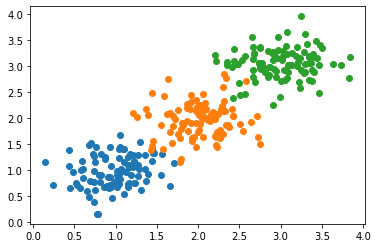

In [76]:
fig, ax = plt.subplots()
for i in range(samples.size(1)):  # バッチ次元
    each_samples = samples[:,i,:]
    each_samples_array = each_samples.numpy()
    ax.scatter(each_samples_array[:,0], each_samples_array[:,1])